In [104]:
import matplotlib.pyplot as plt
import numpy as np
import random
#import abcpy
import treeswift
from treeswift import Tree, Node


class Population:
    def __init__(self, N, generations, s):
        self.N = N
        self.s = s
        self.generations = generations
        self.generation_data = []

    def __str__(self):
        return f"Population size: {self.N}, Generations: {self.generations}, Selection: {self.s}"

    def simulate_population(self):
        """
        Simulate the population using the Wright-Fisher model with selection.
        """

        # Initialize the first population
        population = np.zeros(self.N, dtype=int)
        population[random.randint(0, self.N - 1)] = 1
        self.generation_data.append(population)
        binom_prob_list  = []
        mut_n_list = []
        
        for gen in range(self.generations):
            mut_n = len(np.where(self.generation_data[gen] == 1)[0])
            mut_n_list.append(mut_n)
            
            cancer_p = (1 + self.s) * mut_n / (self.N + (mut_n * self.s))
            binom_prob_list.append(cancer_p)
                
            offspring = np.random.binomial(n=1, p=cancer_p, size=self.N)
            
            num_mutants = [np.count_nonzero(offspring == 1)]
            
            if num_mutants == 0:
                print("Stochastic Extinction")
                self.generation_data.append(offspring)
                num_mutants = [np.count_nonzero(generation == 1) for generation in self.generation_data]
                # Plot the number of mutants over time
                fig, ax = plt.subplots()
                ax.plot(range(len(num_mutants)), np.log(num_mutants))
                ax.set_xlabel("Time in Generations")
                ax.set_ylabel("Number of mutants ln(N)")
                ax.set_title(f"Mutant allele frequency over time (s={self.s})")
                plt.show()
                return(self.generation_data, binom_prob_list, mut_n_list, fig) 
            
            self.generation_data.append(offspring)
            
        # Plot the number of mutants over time
        # Count the number of individuals with a value of 1 in each generation
        num_mutants = [np.count_nonzero(generation == 1) for generation in self.generation_data]
        
        # Plot the number of mutants over time
        fig, ax = plt.subplots()
        ax.plot(range(len(num_mutants)), np.log(num_mutants))
        ax.set_xlabel("Time in Generations")
        ax.set_ylabel("Number of mutants ln(N)")
        ax.set_title(f"Mutant allele frequency over time (s={self.s})")
        plt.show()
        
        return(self.generation_data, binom_prob_list, mut_n_list, fig) 
    

def build_leaf_to_root_connections(tree_mask):
    """
     Simulate the population using the Wright-Fisher model with selection.
    """
    # List of each generation, where each generation is a dict from node_idx to set of leaves
    node_to_leaves = []
    # Initialize the list of generations
    for generation_idx, generation in enumerate(tree_mask):
        node_to_leaves.append({})
        for node_idx, node in enumerate(generation):
            if node == 1:
                node_to_leaves[-1][node_idx] = set()
    # Go backward from leaf to root, randomly assigning each leaf to a parent
    for leaf_idx in node_to_leaves[-1].keys():
        for generation_idx, generation in reversed(
            list(enumerate(node_to_leaves[:-1]))
        ):
            parent_idx = random.choice(list(generation.keys()))
            node_to_leaves[generation_idx][parent_idx].add(
                (len(node_to_leaves) - 1, leaf_idx)
            )
    # Drop any non leaves that weren't connected
    # Create a dict from node coordinates to leaf coordinates
    result = {}
    for generation_idx, generation in enumerate(node_to_leaves):
        for node_idx, leaves in generation.items():
            if generation_idx == len(node_to_leaves) - 1 or len(leaves) > 0:
                result[str((generation_idx, node_idx))] = {str(leaf) for leaf in leaves}
    return result

########  if _name_ == "_main_":
########     build_leaf_to_root_connections(tree_mask)


def clusters_to_nodes(tree_clusters):
    """
    the following function goes from a nested dictionary of clades, creates the root node, adds node to that root 
    and then establishes parent and children relationships    """
    
    label_to_node = {cluster: Node(label=cluster) for cluster in tree_clusters}

    # Connect each node with it's leaves 
    for parent_label, leaf_labels in tree_clusters.items():
        parent_node = label_to_node[parent_label]
        for leaf_label in leaf_labels:
            leaf_node = label_to_node[leaf_label]
            parent_node.add_child(leaf_node)

    # Connect each node with all descendants
    for node1 in label_to_node.values():
        for node2 in label_to_node.values():
            if node1 == node2:
                continue

            possible_parent = node1 if len(node1.child_nodes()) > len(node2.child_nodes()) else node2
            possible_child = node2 if possible_parent is node1 else node1
            
            parent_leaf_labels = {node.label for node in possible_parent.child_nodes()}
            child_leaf_labels = {node.label for node in possible_child.child_nodes()}
            is_descendant = child_leaf_labels.issubset(parent_leaf_labels)

            if is_descendant and possible_child not in possible_parent.child_nodes() and possible_child.child_nodes():
                possible_parent.add_child(possible_child)

########  Remove non-direct descendants
    next_nodes = {label_to_node["1"]}
    while next_nodes:
        node = next_nodes.pop()
        for child in node.child_nodes():
            next_nodes.add(child)
            child.set_parent(node)
            for grandchild in child.child_nodes():
                if grandchild in node.child_nodes():
                    node.remove_child(grandchild)

    # Create the tree using TreeSwift
    tree = Tree()
    tree.root = label_to_node["1"]

    return tree


def assign_edge_lengths(self, mu, tree):
    """
    Iterate through the tree class and assign edge lengths based on a Poisson distribution with mean rate μ.
    """
    for node in tree.nodes():
        length = np.random.poisson(mu)
        node.set_edge_length(length)
    return tree

def read_observed_data(observed_data_path):
    """
    Read observed tree and calculate LTT statistics and return or read in LTT statistics straight
    """

    # Define the path to the file containing the tree
    tree_file = observed_data_path

    # Load the tree from the TSV file
    with open(tree_file) as f:
        tree_str = f.read()
    tree = treeswift.read_tree_newick(tree_str)
    
    # Calculate lineage through time plot statistics
    ltt = tree.lineages_through_time()

    # Save the results in a data structure
    results = {
        "tree": tree,
        "ltt": ltt,
    }
    print("Tree:", results["tree"])
    print("LTT statistics:", results["ltt"])
    return tree,ltt


##### ------------- Wright-Fisher Simulation ------------------------------ #

def simulate_population_and_tree(N, generations, mut_samples, s, mu):
    # initiate population
    popul = Population(N, generations, mut_samples, s) 
    # go from population array to tree_clusters dictionary
    genealogy= build_leaf_to_root_connections(popul)
    # from matrix go to tree_clusters dictionary
    tree_clusters=genealogy_to_cluster(Gen.genealogy) 
    # create phylo tree
    gen_tree = clusters_to_nodes(tree_clusters)
    # assign random edge (branch) lengths
    gen_tree_expanded = assign_edge_lengths(gen_tree, mu)
    # calculate ltt stats and plot using treeswift
    ltt_gen_tree = gen_tree_expanded.lineages_through_time()
    # write tree to newick txt file
    gen_tree.write_tree_newick("output_gen_tree.tree.nwk", hide_rooted_prefix=True)


results = []

for i in range(1000):
    # call the function
    result = simulate_population_and_tree(N, generations, mut_samples, s, mu)
    # append the result to the list
    results.append(result)


    

##### ------------- Approximate Bayesian Criterion ----------------- #
    """
    Set Priors and run ABC analysis using abcpy
    """

##### Distance function between observed and synthetic data
def distance_function():
    """
    Calculate the distance between the observed and synthetic data.
    """

    pass



def estimate_parameters(epsilon):
    # set priors
    s_prior = abcpy.Distribution(stats.uniform, 0, 2) # selection
    
    pass
        

    

NameError: name 'N' is not defined

In [129]:
which python

SyntaxError: invalid syntax (<ipython-input-129-d8603f9f9bc3>, line 1)

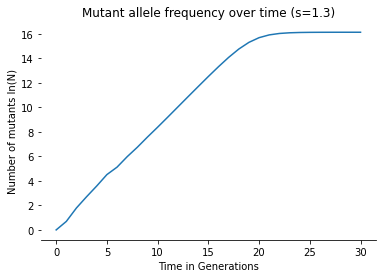

In [100]:
pop = Population(N=10000000, generations=30, s=1.3)
gen, prob, mut, fig = pop.simulate_population()

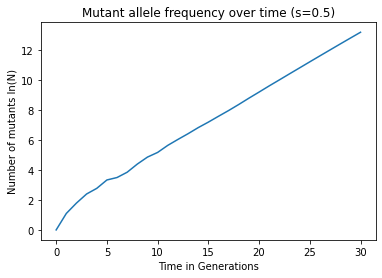

In [310]:
pop = Population(N=10000000, generations=30, s=0.5)
gen, prob, mut, fig = pop.simulate_population()

<ipython-input-104-e427b18135e6>:63: RuntimeWarning: divide by zero encountered in log
  ax.plot(range(len(num_mutants)), np.log(num_mutants))


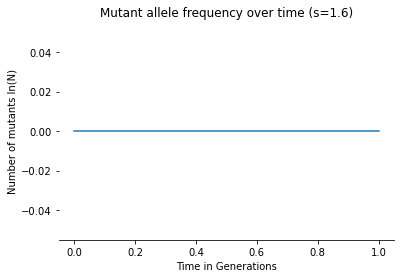

In [128]:
pop = Population(N=2000, generations=30, s=1.6)
gen, prob, mut, fig = pop.simulate_population()

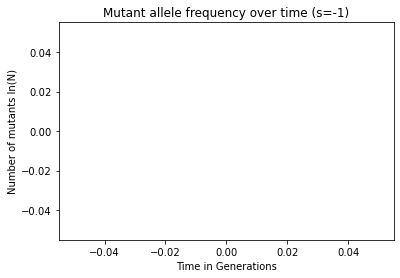

In [336]:
# Example of stochastic extinction
pop = Population(N=10000000, generations=30, s=0.3)
gen, prob, mut, fig = pop.simulate_population()

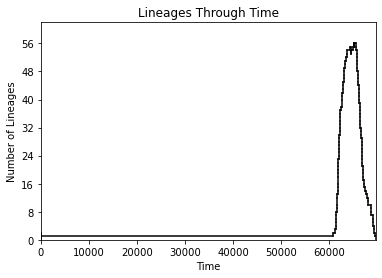

Tree: (ROOT:1,(COLO_278_06:6241,((COLO_278_55:7131,((COLO_278_31:6394,(COLO_278_01:4554,(COLO_278_51:4638,COLO_278_54:4097)100:2815):16)100:54,(COLO_278_09:2186,(COLO_278_07:901,COLO_278_22:2709)100:1434)100:1501)100:204)100:770,(((COLO_278_18:4791,(((COLO_278_02:3348,((COLO_278_21:4063,(COLO_278_44:3496,(COLO_278_45:2787,COLO_278_46:3154)100:323)100:281)100:496,((COLO_278_33:2911,(COLO_278_41:3735,COLO_278_73:3133)100:198)100:902,(COLO_278_50:3690,COLO_278_60:3361)100:1250)100:131)100:85)100:52,(COLO_278_28:5115,(((COLO_278_16:3020,COLO_278_59:3442)100:341,(COLO_278_65:3230,(COLO_278_25:3948,COLO_278_72:3048)100:275)100:346)100:216,(((COLO_278_24:3510,COLO_278_36:3747)100:424,(COLO_278_42:2206,COLO_278_47:2131)100:1972)100:228,(COLO_278_38:4358,COLO_278_39:3648)100:343)100:20)100:311)100:46)100:0,((COLO_278_11:2680,COLO_278_56:5715)100:186,(((COLO_278_15:2576,COLO_278_71:5211)100:94,(COLO_278_62:3372,COLO_278_66:3530)100:1526)100:106,(COLO_278_43:5155,(COLO_278_34:4149,(COLO_278_37:31

In [338]:
# Read Organoid 278 tree
observed_data_path = "/Users/mkalyva/DATA/MSI_evolution_2022/Organoid_278/Work_2023/Plots/consense_mpboot_org278_newick.tree"
# add function to average branch length
tree, ltt = read_observed_data(observed_data_path)

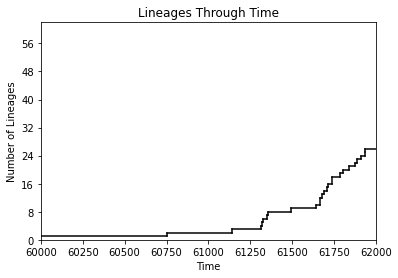

{0.0: 2,
 1.0: 1,
 60754.0: 2,
 61140.0: 3,
 61313.0: 4,
 61323.0: 5,
 61325.0: 6,
 61349.0: 7,
 61357.0: 8,
 61496.0: 9,
 61646.0: 10,
 61665.0: 12,
 61678.0: 13,
 61688.0: 14,
 61711.0: 15,
 61717.0: 16,
 61737.0: 18,
 61788.0: 19,
 61802.0: 20,
 61843.0: 21,
 61874.0: 22,
 61887.0: 23,
 61910.0: 24,
 61933.0: 25,
 61937.0: 26,
 62022.0: 27,
 62042.0: 28,
 62073.0: 29,
 62083.0: 30,
 62114.0: 31,
 62149.0: 32,
 62168.0: 33,
 62184.0: 34,
 62238.0: 35,
 62270.0: 36,
 62298.0: 37,
 62385.0: 38,
 62579.0: 40,
 62584.0: 41,
 62694.0: 42,
 62835.0: 43,
 62859.0: 44,
 62902.0: 45,
 62966.0: 46,
 62977.0: 47,
 63033.0: 48,
 63064.0: 49,
 63183.0: 50,
 63189.0: 51,
 63369.0: 52,
 63615.0: 53,
 63723.0: 54,
 64242.0: 55,
 64513.0: 54,
 64554.0: 53,
 64563.0: 54,
 64999.0: 55,
 65049.0: 56,
 65065.0: 55,
 65091.0: 56,
 65549.0: 55,
 65599.0: 54,
 65689.0: 53,
 65740.0: 52,
 65746.0: 51,
 65777.0: 50,
 65801.0: 49,
 65814.0: 48,
 65907.0: 47,
 65950.0: 46,
 66021.0: 45,
 66033.0: 44,
 66056.0: 

In [324]:
tree.lineages_through_time(xmin=60000,xmax=62000)

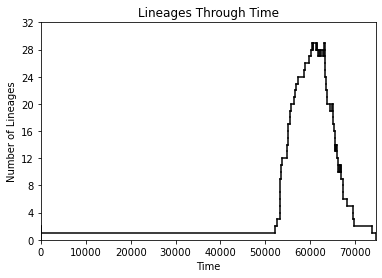

Tree: (ROOT:1,(COLO_027_31:21527,((((COLO_027_36:14112,((((COLO_027_12:10828,(COLO_027_11:3685,(COLO_027_42:407,COLO_027_44:310)100:4545)100:7029):18,(COLO_027_15:6332,(COLO_027_23:748,COLO_027_21:771)100:8056)100:143)100:1093,(COLO_027_35:11849,(COLO_027_24:3544,(COLO_027_48:282,COLO_027_50:314)100:6005)100:4765)100:1310)100:388,(((((COLO_027_19:3564,COLO_027_52:4082)100:732,(COLO_027_53:325,COLO_027_55:233)100:4900)100:1785,(COLO_027_27:521,COLO_027_25:579)100:7878)100:2186,(COLO_027_17:10931,COLO_027_51:12338)100:589)100:3397,(COLO_027_5:6351,((COLO_027_33:1998,(COLO_027_28:1314,COLO_027_7:1227)100:1672)100:2411,(COLO_027_18:343,COLO_027_20:489)100:6732)100:534)100:2384)100:0)100:86)100:8,((COLO_027_22:11578,(COLO_027_16:16095,(COLO_027_10:8317,(COLO_027_32:469,COLO_027_34:808)100:7424)100:1460)100:68)100:131,(COLO_027_49:7838,(COLO_027_26:6896,(COLO_027_45:524,COLO_027_47:464)100:8409)100:976)100:2223)100:47)100:16,(COLO_027_3:9636,COLO_027_30:8801)100:2279)100:639,(COLO_027_29:930

In [325]:
# Read Organoid 027 tree
observed_data_path = "/Users/mkalyva/DATA/MSI_evolution_2022/Organoid_027/Work_2023/Plots/consense_mpboot_org027_newick.tree"
tree, ltt = read_observed_data(observed_data_path)

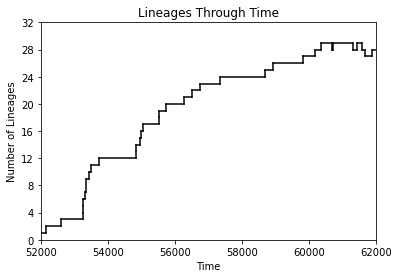

{0.0: 2,
 1.0: 1,
 52156.0: 2,
 52603.0: 3,
 53242.0: 4,
 53258.0: 5,
 53266.0: 6,
 53305.0: 7,
 53352.0: 9,
 53436.0: 10,
 53504.0: 11,
 53740.0: 12,
 54833.0: 13,
 54851.0: 14,
 54964.0: 15,
 54976.0: 16,
 55050.0: 17,
 55521.0: 18,
 55528.0: 19,
 55736.0: 20,
 56270.0: 21,
 56504.0: 22,
 56749.0: 23,
 57338.0: 24,
 58681.0: 25,
 58935.0: 26,
 59815.0: 27,
 60193.0: 28,
 60353.0: 29,
 60679.0: 28,
 60720.0: 29,
 61308.0: 28,
 61452.0: 29,
 61580.0: 28,
 61667.0: 27,
 61880.0: 28,
 62087.0: 27,
 62388.0: 28,
 62857.0: 27,
 63002.0: 28,
 63032.0: 29,
 63196.0: 28,
 63281.0: 27,
 63345.0: 26,
 63359.0: 25,
 63366.0: 24,
 63400.0: 23,
 63491.0: 22,
 63780.0: 21,
 63803.0: 20,
 64322.0: 19,
 64913.0: 20,
 65014.0: 19,
 65016.0: 18,
 65157.0: 17,
 65377.0: 16,
 65437.0: 15,
 65534.0: 14,
 65565.0: 13,
 65620.0: 14,
 65679.0: 13,
 65820.0: 14,
 65853.0: 13,
 65945.0: 12,
 66102.0: 11,
 66134.0: 10,
 66425.0: 11,
 66735.0: 10,
 66813.0: 11,
 66832.0: 10,
 66899.0: 9,
 67334.0: 8,
 67378.0: 7

In [327]:
tree.lineages_through_time(xmin=52000,xmax=62000)

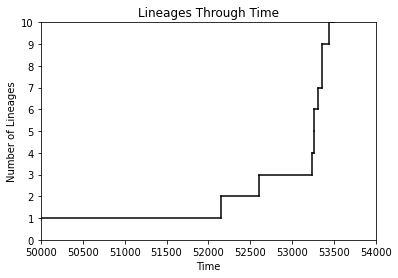

{0.0: 2,
 1.0: 1,
 52156.0: 2,
 52603.0: 3,
 53242.0: 4,
 53258.0: 5,
 53266.0: 6,
 53305.0: 7,
 53352.0: 9,
 53436.0: 10,
 53504.0: 11,
 53740.0: 12,
 54833.0: 13,
 54851.0: 14,
 54964.0: 15,
 54976.0: 16,
 55050.0: 17,
 55521.0: 18,
 55528.0: 19,
 55736.0: 20,
 56270.0: 21,
 56504.0: 22,
 56749.0: 23,
 57338.0: 24,
 58681.0: 25,
 58935.0: 26,
 59815.0: 27,
 60193.0: 28,
 60353.0: 29,
 60679.0: 28,
 60720.0: 29,
 61308.0: 28,
 61452.0: 29,
 61580.0: 28,
 61667.0: 27,
 61880.0: 28,
 62087.0: 27,
 62388.0: 28,
 62857.0: 27,
 63002.0: 28,
 63032.0: 29,
 63196.0: 28,
 63281.0: 27,
 63345.0: 26,
 63359.0: 25,
 63366.0: 24,
 63400.0: 23,
 63491.0: 22,
 63780.0: 21,
 63803.0: 20,
 64322.0: 19,
 64913.0: 20,
 65014.0: 19,
 65016.0: 18,
 65157.0: 17,
 65377.0: 16,
 65437.0: 15,
 65534.0: 14,
 65565.0: 13,
 65620.0: 14,
 65679.0: 13,
 65820.0: 14,
 65853.0: 13,
 65945.0: 12,
 66102.0: 11,
 66134.0: 10,
 66425.0: 11,
 66735.0: 10,
 66813.0: 11,
 66832.0: 10,
 66899.0: 9,
 67334.0: 8,
 67378.0: 7

In [331]:
tree.lineages_through_time(xmin=50000,xmax=54000, ymax=10)

In [2]:
def build_leaf_to_root_connections(tree_mask):
    """
     Simulate the population using the Wright-Fisher model with selection.
    """
    # List of each generation, where each generation is a dict from node_idx to set of leaves
    node_to_leaves = []
    # Initialize the list of generations
    for generation_idx, generation in enumerate(tree_mask):
        node_to_leaves.append({})
        for node_idx, node in enumerate(generation):
            if node == 1:
                node_to_leaves[-1][node_idx] = set()
    # Go backward from leaf to root, randomly assigning each leaf to a parent
    for leaf_idx in node_to_leaves[-1].keys():
        for generation_idx, generation in reversed(
            list(enumerate(node_to_leaves[:-1]))
        ):
            parent_idx = random.choice(list(generation.keys()))
            node_to_leaves[generation_idx][parent_idx].add(
                (len(node_to_leaves) - 1, leaf_idx)
            )
    # Drop any non leaves that weren't connected
    # Create a dict from node coordinates to leaf coordinates
    result = {}
    for generation_idx, generation in enumerate(node_to_leaves):
        for node_idx, leaves in generation.items():
            if generation_idx == len(node_to_leaves) - 1 or len(leaves) > 0:
                result[str((generation_idx, node_idx))] = {str(leaf) for leaf in leaves}
    return result

In [5]:
def build_leaf_to_root_connections(tree_mask):
    """
     Simulate the population using the Wright-Fisher model with selection.
    """
    # List of each generation, where each generation is a dict from node_idx to set of leaves
    node_to_leaves = []

    # Initialize the list of generations
    for generation_idx, generation in enumerate(tree_mask):
        node_to_leaves.append({})
        for node_idx, node in enumerate(generation):
            if node == 1:
                node_to_leaves[-1][node_idx] = set()

    # Go backward from leaf to root, randomly assigning each leaf to a parent
    for leaf_idx in node_to_leaves[-1].keys():
        leaf_to_follow = None
        for generation_idx, generation in reversed(
            list(enumerate(node_to_leaves[:-1]))
        ):
            # If we already have a leaf to follow, pick it's ancestor, otherwise pick a random one
            if leaf_to_follow is not None:
                parent_idx = next(
                    node
                    for node, leaves in generation.items()
                    if leaf_to_follow in leaves
                )
            else:
                parent_idx = random.choice(list(generation.keys()))

            # If the parent already has a leaf, pick it's ancestor in all previous generations to avoid cycles
            if len(node_to_leaves[generation_idx][parent_idx]) > 0:
                leaf_to_follow = list(node_to_leaves[generation_idx][parent_idx])[0]

            # Add the leaf to the parent
            node_to_leaves[generation_idx][parent_idx].add(
                (len(node_to_leaves) - 1, leaf_idx)
            )

    # Drop any non leaves that weren't connected
    # Create a dict from node coordinates to leaf coordinates
    result = {}
    for generation_idx, generation in enumerate(node_to_leaves):
        for node_idx, leaves in generation.items():
            if generation_idx == len(node_to_leaves) - 1 or len(leaves) > 0:
                result[str((generation_idx, node_idx))] = {str(leaf) for leaf in leaves}

    return result

In [60]:
def clusters_to_nodes(tree_clusters):
    """
    the following function goes from a nested dictionary of clades, creates the root node, adds node to that root 
    and then establishes parent and children relationships    """
    
    label_to_node = {cluster: Node(label=cluster) for cluster in tree_clusters}
    root_name = list(tree_clusters.keys())[0]
    
    # Connect each node with it's leaves 
    for parent_label, leaf_labels in tree_clusters.items():
        parent_node = label_to_node[parent_label]
        for leaf_label in leaf_labels:
            leaf_node = label_to_node[leaf_label]
            parent_node.add_child(leaf_node)

    # Connect each node with all descendants
    for node1 in label_to_node.values():
        for node2 in label_to_node.values():
            if node1 == node2:
                continue

            node_1_gen = int(node1.label.split(',')[0][1:]) # split the key on comma, take the first element, and remove the opening parenthesis
            node_2_gen = int(node2.label.split(',')[0][1:]) # split the key on comma, take the first element, and remove the opening parenthesis
            
            if abs(node_2_gen - node_1_gen) > 1 :
                continue
            
            possible_parent = node1 if len(node1.child_nodes()) > len(node2.child_nodes()) else node2
            possible_child = node2 if possible_parent is node1 else node1
            
            parent_leaf_labels = {node.label for node in possible_parent.child_nodes()}
            child_leaf_labels = {node.label for node in possible_child.child_nodes()}
            is_descendant = child_leaf_labels.issubset(parent_leaf_labels)

            if is_descendant and possible_child not in possible_parent.child_nodes() and possible_child.child_nodes():
                possible_parent.add_child(possible_child)

########  Remove non-direct descendants
    next_nodes = {label_to_node[root_name]}
    while next_nodes:
        node = next_nodes.pop()
        for child in node.child_nodes():
            next_nodes.add(child)
            child.set_parent(node)
            for grandchild in child.child_nodes():
                if grandchild in node.child_nodes():
                    node.remove_child(grandchild)

    # Create the tree using TreeSwift
    tree = Tree()
    tree.root = label_to_node[root_name]

    return tree

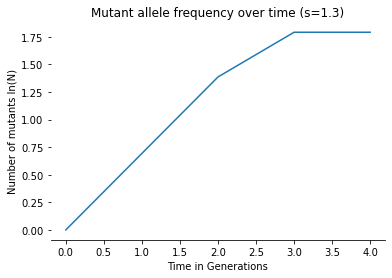

In [67]:
pop = Population(N=6, generations=4, s=1.3)
gen, prob, mut, fig = pop.simulate_population()

In [68]:
clusters = build_leaf_to_root_connections(gen)

In [69]:
clusters

{'(0, 2)': {'(4, 0)', '(4, 1)', '(4, 2)', '(4, 3)', '(4, 4)', '(4, 5)'},
 '(1, 2)': {'(4, 1)', '(4, 4)'},
 '(1, 3)': {'(4, 0)', '(4, 2)', '(4, 3)', '(4, 5)'},
 '(2, 0)': {'(4, 2)'},
 '(2, 2)': {'(4, 1)', '(4, 4)'},
 '(2, 5)': {'(4, 0)', '(4, 3)', '(4, 5)'},
 '(3, 0)': {'(4, 3)', '(4, 5)'},
 '(3, 1)': {'(4, 0)'},
 '(3, 2)': {'(4, 2)'},
 '(3, 5)': {'(4, 1)', '(4, 4)'},
 '(4, 0)': set(),
 '(4, 1)': set(),
 '(4, 2)': set(),
 '(4, 3)': set(),
 '(4, 4)': set(),
 '(4, 5)': set()}

In [70]:
tree_run = clusters_to_nodes(clusters)

In [94]:
def assign_edge_lengths(mu, tree):
    """
    Iterate through the tree class and assign edge lengths based on a Poisson distribution with mean rate μ.
    """
    for node in tree.traverse_preorder():
        length = np.random.poisson(mu)
        node.set_edge_length(length)
    return tree

In [72]:
tree_run.write_tree_newick('output.tre') 

In [65]:
clusters

{'(0, 1)': {'(4, 0)', '(4, 1)', '(4, 2)', '(4, 3)', '(4, 4)'},
 '(1, 4)': {'(4, 0)', '(4, 1)', '(4, 2)', '(4, 3)', '(4, 4)'},
 '(2, 4)': {'(4, 0)', '(4, 1)', '(4, 2)', '(4, 3)', '(4, 4)'},
 '(3, 0)': {'(4, 1)', '(4, 3)'},
 '(3, 2)': {'(4, 4)'},
 '(3, 3)': {'(4, 2)'},
 '(3, 4)': {'(4, 0)'},
 '(4, 0)': set(),
 '(4, 1)': set(),
 '(4, 2)': set(),
 '(4, 3)': set(),
 '(4, 4)': set()}

In [80]:
tree_string = tree_run.newick()
tree_string
# this is True

"[&R] (('(4, 1)','(4, 4)')'(1, 2)',(('(4, 2)')'(2, 0)',(('(4, 5)','(4, 3)')'(3, 0)',('(4, 0)')'(3, 1)')'(2, 5)')'(1, 3)')'(0, 2)';"

In [95]:
from treeswift import read_tree_newick
tree = read_tree_newick(tree_string)
tree_lengths = assign_edge_lengths(100,tree)

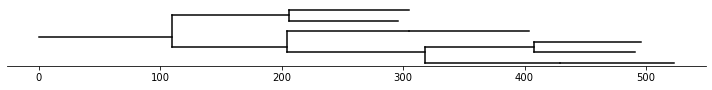

In [97]:
tree_lengths.draw()